# Expectation-Maximization (EM) Algorithm

This notebook covers the **Expectation-Maximization (EM) algorithm** as described in
**Chapter 20 — Learning Probabilistic Models** of *Artificial Intelligence: A Modern Approach*
and the CSE 150A lectures.

EM is a general technique for finding maximum likelihood estimates of parameters in models
with **latent (hidden) variables**. We implement EM for three model families:

1. **Bayesian Networks** with missing data
2. **Hidden Markov Models** (the Baum-Welch algorithm)
3. **Noisy-OR models** with auxiliary latent variables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product as iter_product

np.random.seed(42)
%matplotlib inline

## Contents

- [The EM Algorithm](#the-em-algorithm)
    - ML estimation for complete data
    - EM for incomplete data
    - Key properties
- [EM for Bayesian Networks](#em-for-bayesian-networks)
    - BayesNode and BayesNet (review)
    - Parameter learning with complete data
    - Parameter learning with hidden variables
    - Demo: hidden cause network
- [EM for Hidden Markov Models: Baum-Welch](#em-for-hidden-markov-models-baum-welch)
    - Forward and backward algorithms (review)
    - E-step: computing posteriors from α and β
    - M-step: re-estimating π_i, a_ij, b_ik
    - Demo: ice cream / weather
- [EM for Noisy-OR Models](#em-for-noisy-or-models)
    - The Noisy-OR parameterization
    - Augmented model with latent Z_i variables
    - EM updates for p_i
    - Demo: medical diagnosis
- [Demos and Visualizations](#demos-and-visualizations)
    - Convergence plots
    - Sensitivity to initialization

## The EM Algorithm

<a id="the-em-algorithm"></a>

### ML Estimation for Complete Data

**Notation.** Let $X_1, X_2, \ldots, X_n$ be the nodes in a Bayesian network.
We have $T$ training examples, indexed by $t = 1, 2, \ldots, T$.
The complete data is $\{(x_{1t}, x_{2t}, \ldots, x_{nt})\}_{t=1}^{T}$.

When all variables are observed, maximum likelihood estimates for the CPTs are simple
ratios of counts:

**Root nodes:**

$$P_{\text{ML}}(X_i = x) = \frac{\text{count}(X_i = x)}{T} = \frac{1}{T} \sum_t I(x_{it}, x)$$

**Nodes with parents:**

$$P_{\text{ML}}(X_i = x \mid pa_i = \pi) = \frac{\sum_t I(x_{it}, x)\, I(pa_{it}, \pi)}{\sum_t I(pa_{it}, \pi)}$$

where $I(x_{it}, x)$ is the indicator function: 1 if $X_i = x$ in example $t$, 0 otherwise.

### EM for Incomplete Data

Now suppose some nodes are hidden — that is, not observed in the training data.
Let $V_t = v_t$ denote the visible (observed) nodes for the $t^{\text{th}}$ example.

We can no longer simply count. Instead, EM replaces **hard counts** with
**expected counts** under the current parameters:

> **Initialize** CPTs to nonzero values.
>
> **Repeat until convergence:**
>
> &emsp; **E-step** — compute posterior probabilities.
>
> &emsp; **M-step** — update CPTs:
>
> &emsp;&emsp; *Root nodes:*
> $$P(X_i = x) \leftarrow \frac{1}{T} \sum_t P(X_i = x \mid V_t = v_t)$$
>
> &emsp;&emsp; *Nodes with parents:*
> $$P(X_i = x \mid pa_i = \pi) \leftarrow \frac{\sum_t P(X_i = x, \; pa_i = \pi \mid V_t = v_t)}{\sum_t P(pa_i = \pi \mid V_t = v_t)}$$

### Complete vs Incomplete Data — Side by Side

| | Complete data | Incomplete data (EM) |
|---|---|---|
| **Root nodes** | $P(X_i{=}x) = \frac{1}{T}\sum_t I(x_{it}, x)$ | $P(X_i{=}x) \leftarrow \frac{1}{T}\sum_t P(X_i{=}x \mid V_t{=}v_t)$ |
| **Nodes with parents** | $\frac{\sum_t I(x_{it},x)\,I(pa_{it},\pi)}{\sum_t I(pa_{it},\pi)}$ | $\frac{\sum_t P(X_i{=}x,\, pa_i{=}\pi \mid V_t{=}v_t)}{\sum_t P(pa_i{=}\pi \mid V_t{=}v_t)}$ |

The pattern is clear: **hard indicators $I(\cdot)$ become soft posteriors $P(\cdot \mid V_t = v_t)$**.

### Key Properties of EM

- **No learning rate.** Unlike gradient-based methods, EM updates do not require tuning a
  learning rate $\eta > 0$.

- **Monotonic convergence.** Changes to CPTs from the EM updates always increase the
  incomplete-data log-likelihood $L = \sum_t \log P(V_t = v_t)$.

- **Local optima.** EM converges to a local maximum, not necessarily the global one.
  Initialization matters.

## EM for Bayesian Networks

<a id="em-for-bayesian-networks"></a>

We now implement the general EM algorithm for learning CPTs in a Bayesian network when
some variables are hidden.

### Review: BayesNode and BayesNet

We define the `BayesNode` and `BayesNet` classes inline. (These match `probability.py`.)

In [ ]:
# ---------- helpers from utils.py ----------
def extend(s, var, val):
    """Copy dict s and extend it by setting var to val; return copy."""
    return {**s, var: val}

def product(numbers):
    """Return the product of the numbers, e.g. product([2, 3, 10]) == 60"""
    from functools import reduce
    import operator
    return reduce(operator.mul, numbers, 1)

def probability(p):
    """Return True with probability p."""
    return np.random.random() < p

In [ ]:
class ProbDist:
    """A discrete probability distribution."""

    def __init__(self, var_name='?', freq=None):
        self.prob = {}
        self.var_name = var_name
        self.values = []
        if freq:
            for (v, p) in freq.items():
                self[v] = p
            self.normalize()

    def __getitem__(self, val):
        try:
            return self.prob[val]
        except KeyError:
            return 0

    def __setitem__(self, val, p):
        if val not in self.values:
            self.values.append(val)
        self.prob[val] = p

    def normalize(self):
        total = sum(self.prob.values())
        if not np.isclose(total, 1.0):
            for val in self.prob:
                self.prob[val] /= total
        return self

    def show_approx(self, numfmt='{:.3g}'):
        return ', '.join([('{}: ' + numfmt).format(v, p)
                          for (v, p) in sorted(self.prob.items())])

    def __repr__(self):
        return "P({})".format(self.var_name)

In [ ]:
def event_values(event, variables):
    """Return a tuple of the values of variables in event."""
    if isinstance(event, tuple) and len(event) == len(variables):
        return event
    else:
        return tuple([event[var] for var in variables])


class BayesNode:
    """A conditional probability distribution for a boolean variable, P(X | parents)."""

    def __init__(self, X, parents, cpt):
        if isinstance(parents, str):
            parents = parents.split()

        if isinstance(cpt, (float, int)):
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v,): p for v, p in cpt.items()}

        self.variable = X
        self.parents = parents
        self.cpt = cpt
        self.children = []

    def p(self, value, event):
        """Return P(X=value | parents as given in event)."""
        assert isinstance(value, bool)
        ptrue = self.cpt[event_values(event, self.parents)]
        return ptrue if value else 1 - ptrue

    def sample(self, event):
        return probability(self.p(True, event))

    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))


class BayesNet:
    """Bayesian network containing only boolean-variable nodes."""

    def __init__(self, node_specs=None):
        self.nodes = []
        self.variables = []
        node_specs = node_specs or []
        for node_spec in node_specs:
            self.add(node_spec)

    def add(self, node_spec):
        node = BayesNode(*node_spec)
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.variable_node(parent).children.append(node)

    def variable_node(self, var):
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))

    def variable_values(self, var):
        return [True, False]

    def __repr__(self):
        return 'BayesNet({0!r})'.format(self.nodes)

In [ ]:
def enumerate_all(variables, e, bn):
    """Return the sum of those entries in P(variables | e{others}) consistent with e."""
    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.variable_node(Y)
    if Y in e:
        return Ynode.p(e[Y], e) * enumerate_all(rest, e, bn)
    else:
        return sum(Ynode.p(y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.variable_values(Y))


def enumeration_ask(X, e, bn):
    """Return the conditional probability distribution of variable X given evidence e."""
    assert X not in e, "Query variable must be distinct from evidence"
    Q = ProbDist(X)
    for xi in bn.variable_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()


def prior_sample(bn):
    """Sample from bn's full joint distribution. Returns {variable: value} dict."""
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

In [ ]:
# Quick review: the burglary network
T, F = True, False

burglary = BayesNet([
    ('Burglary', '', 0.001),
    ('Earthquake', '', 0.002),
    ('Alarm', 'Burglary Earthquake',
     {(T,T): 0.95, (T,F): 0.94, (F,T): 0.29, (F,F): 0.001}),
    ('JohnCalls', 'Alarm', {T: 0.90, F: 0.05}),
    ('MaryCalls', 'Alarm', {T: 0.70, F: 0.01}),
])

print("P(Burglary | JohnCalls=T, MaryCalls=T):")
print(enumeration_ask('Burglary', dict(JohnCalls=T, MaryCalls=T), burglary).show_approx())

### Parameter Learning with Complete Data

Before tackling EM, we implement the simple case: all variables observed.

For each node $X_i$ with parents $pa_i$, we compute:

$$P_{\text{ML}}(X_i = x \mid pa_i = \pi) = \frac{\sum_t I(x_{it}, x)\, I(pa_{it}, \pi)}{\sum_t I(pa_{it}, \pi)}$$

In [ ]:
def bn_learn_complete(bn_structure, data):
    """Learn BayesNet parameters from fully observed data.

    Parameters
    ----------
    bn_structure : list of (variable_name, parents_string) pairs
        Defines the DAG structure only — no CPT values needed.
    data : list of dicts
        Each dict maps variable_name -> True/False (all vars observed).

    Returns
    -------
    BayesNet with ML-estimated CPTs.
    """
    T = len(data)
    node_specs = []

    for var, parents_str in bn_structure:
        parents = parents_str.split() if parents_str else []

        if not parents:
            # Root node: P_ML(X_i = True) = count(X_i = True) / T
            count_true = sum(1 for d in data if d[var])
            p_true = count_true / T
            # Clamp away from 0/1 for numerical safety
            p_true = np.clip(p_true, 1e-6, 1 - 1e-6)
            node_specs.append((var, parents_str, float(p_true)))
        else:
            # Node with parents: P_ML(X_i = True | pa_i = π)
            cpt = {}
            for parent_vals in iter_product([True, False], repeat=len(parents)):
                parent_count = sum(
                    1 for d in data
                    if all(d[p] == v for p, v in zip(parents, parent_vals))
                )
                joint_count = sum(
                    1 for d in data
                    if d[var] and all(d[p] == v for p, v in zip(parents, parent_vals))
                )
                if parent_count > 0:
                    p_true = joint_count / parent_count
                else:
                    p_true = 0.5  # no data for this parent config
                p_true = np.clip(p_true, 1e-6, 1 - 1e-6)
                cpt[parent_vals] = float(p_true)
            node_specs.append((var, parents_str, cpt))

    return BayesNet(node_specs)

In [ ]:
# Demo: generate data from burglary net, learn CPTs back, compare
np.random.seed(42)
N_SAMPLES = 10000
data_complete = [prior_sample(burglary) for _ in range(N_SAMPLES)]

structure = [('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'),
             ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')]

learned_bn = bn_learn_complete(structure, data_complete)

print("Complete-data ML estimation ({} samples)".format(N_SAMPLES))
print("=" * 60)
for orig, learned in zip(burglary.nodes, learned_bn.nodes):
    print(f"\n{orig.variable}:")
    for parent_vals in sorted(orig.cpt.keys()):
        true_p = orig.cpt[parent_vals]
        learned_p = learned.cpt[parent_vals]
        label = str(parent_vals) if parent_vals else "()"
        print(f"  pa={label:20s}  true={true_p:.4f}  learned={learned_p:.4f}")

### Parameter Learning with Hidden Variables

Now suppose some variables are unobserved. The visible nodes for example $t$ are
$V_t = v_t$.

**E-step:** For each example $t$, compute posteriors $P(X_i = x, \; pa_i = \pi \mid V_t = v_t)$
using inference (`enumeration_ask`) with the current CPTs.

**M-step:** Update CPTs using expected counts:

*Root nodes:* $\; P(X_i = x) \leftarrow \frac{1}{T}\sum_t P(X_i = x \mid V_t = v_t)$

*Nodes with parents:* $\; P(X_i = x \mid pa_i = \pi) \leftarrow \frac{\sum_t P(X_i = x, \; pa_i = \pi \mid V_t = v_t)}{\sum_t P(pa_i = \pi \mid V_t = v_t)}$

In [ ]:
def em_bayes_net(bn_structure, data, n_iter=50, tol=1e-4, verbose=True):
    """EM algorithm for learning BayesNet CPTs with hidden variables.

    Parameters
    ----------
    bn_structure : list of (variable_name, parents_string) pairs
    data : list of dicts  {var: True/False/None}
        None means the variable is unobserved (hidden) for that example.
    n_iter : max EM iterations
    tol : convergence threshold on log-likelihood change

    Returns
    -------
    (learned_bn, log_likelihoods) — the final BayesNet and per-iteration log-LL.
    """
    all_vars = [var for var, _ in bn_structure]
    hidden_per_example = []
    evidence_per_example = []
    for d in data:
        ev = {k: v for k, v in d.items() if v is not None}
        hid = [k for k, v in d.items() if v is None]
        evidence_per_example.append(ev)
        hidden_per_example.append(hid)

    # --- Initialize CPTs randomly ---
    node_specs = []
    for var, parents_str in bn_structure:
        parents = parents_str.split() if parents_str else []
        if not parents:
            p = np.random.uniform(0.3, 0.7)
            node_specs.append((var, parents_str, float(p)))
        else:
            cpt = {}
            for pv in iter_product([True, False], repeat=len(parents)):
                cpt[pv] = float(np.random.uniform(0.2, 0.8))
            node_specs.append((var, parents_str, cpt))

    bn = BayesNet(node_specs)
    log_likelihoods = []

    for iteration in range(n_iter):
        # ---- E-step: compute expected counts ----
        # For each node, accumulate expected counts
        expected_joint = {}   # (var, parent_vals, var_val) -> float
        expected_parent = {}  # (var, parent_vals) -> float

        for node in bn.nodes:
            var = node.variable
            parents = node.parents
            for pv in iter_product([True, False], repeat=len(parents)):
                for xv in [True, False]:
                    expected_joint[(var, pv, xv)] = 0.0
                expected_parent[(var, pv)] = 0.0

        total_ll = 0.0

        for t, (evidence, hidden) in enumerate(zip(evidence_per_example, hidden_per_example)):
            if not hidden:
                # All variables observed — use hard counts
                d = data[t]
                p_evidence = enumerate_all(bn.variables, d, bn)
                if p_evidence > 0:
                    total_ll += np.log(p_evidence)

                for node in bn.nodes:
                    var = node.variable
                    parents = node.parents
                    pv = tuple(d[p] for p in parents)
                    expected_joint[(var, pv, d[var])] += 1.0
                    expected_parent[(var, pv)] += 1.0
            else:
                # Some variables hidden — enumerate over hidden assignments
                p_evidence = enumerate_all(bn.variables, evidence, bn)
                if p_evidence > 0:
                    total_ll += np.log(p_evidence)

                # Enumerate all assignments to hidden variables
                for hv in iter_product([True, False], repeat=len(hidden)):
                    full_assignment = dict(evidence)
                    for h, v in zip(hidden, hv):
                        full_assignment[h] = v

                    # P(full_assignment) from the BN
                    p_full = enumerate_all(bn.variables, full_assignment, bn)
                    if p_evidence > 0:
                        weight = p_full / p_evidence  # P(hidden | visible)
                    else:
                        weight = 0.0

                    for node in bn.nodes:
                        var = node.variable
                        parents = node.parents
                        pv = tuple(full_assignment[p] for p in parents)
                        expected_joint[(var, pv, full_assignment[var])] += weight
                        expected_parent[(var, pv)] += weight

        log_likelihoods.append(total_ll)

        if verbose and (iteration < 5 or iteration % 10 == 0):
            print(f"  Iteration {iteration:3d}:  log-likelihood = {total_ll:.4f}")

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print(f"  Converged at iteration {iteration}.")
            break

        # ---- M-step: update CPTs ----
        new_specs = []
        for var, parents_str in bn_structure:
            parents = parents_str.split() if parents_str else []
            if not parents:
                # Root node: P(X_i = True) <- (1/T) sum_t P(X_i = True | V_t)
                num = expected_joint[(var, (), True)]
                denom = expected_joint[(var, (), True)] + expected_joint[(var, (), False)]
                p_true = num / denom if denom > 0 else 0.5
                p_true = np.clip(p_true, 1e-6, 1 - 1e-6)
                new_specs.append((var, parents_str, float(p_true)))
            else:
                cpt = {}
                for pv in iter_product([True, False], repeat=len(parents)):
                    num = expected_joint[(var, pv, True)]
                    denom = expected_parent[(var, pv)]
                    p_true = num / denom if denom > 0 else 0.5
                    p_true = np.clip(p_true, 1e-6, 1 - 1e-6)
                    cpt[pv] = float(p_true)
                new_specs.append((var, parents_str, cpt))

        bn = BayesNet(new_specs)

    return bn, log_likelihoods

### Demo: Hidden Cause Network

Consider a simple 3-node network: **Hidden → Obs1**, **Hidden → Obs2**. The variable
*Hidden* is never observed. We generate data from known ground-truth CPTs, remove the
Hidden column, and run EM to recover the parameters.

In [ ]:
# Ground truth: Hidden -> Obs1, Hidden -> Obs2
true_bn = BayesNet([
    ('Hidden', '', 0.3),
    ('Obs1', 'Hidden', {T: 0.9, F: 0.2}),
    ('Obs2', 'Hidden', {T: 0.8, F: 0.1}),
])

# Generate data with Hidden observed (for ground truth)
np.random.seed(123)
full_data = [prior_sample(true_bn) for _ in range(500)]

# Create incomplete data: hide the Hidden variable
incomplete_data = [{k: (v if k != 'Hidden' else None) for k, v in d.items()} for d in full_data]

print("Running EM on 500 examples (Hidden variable never observed)...")
print()

structure = [('Hidden', ''), ('Obs1', 'Hidden'), ('Obs2', 'Hidden')]
learned_bn, lls = em_bayes_net(structure, incomplete_data, n_iter=100, tol=1e-6)

print()
print("Parameter comparison:")
print("=" * 60)
for true_node, learned_node in zip(true_bn.nodes, learned_bn.nodes):
    print(f"\n{true_node.variable}:")
    for pv in sorted(true_node.cpt.keys()):
        tp = true_node.cpt[pv]
        lp = learned_node.cpt[pv]
        label = str(pv) if pv else "()"
        print(f"  pa={label:12s}  true P(True)={tp:.4f}  learned={lp:.4f}")

print()
print("Note: EM may learn 'flipped' parameters (label switching)")
print("where the role of Hidden=True and Hidden=False are swapped.")
print("This is expected — the model is equivalent up to relabeling.")

## EM for Hidden Markov Models: Baum-Welch

<a id="em-for-hidden-markov-models-baum-welch"></a>

**Setup.** An HMM has hidden states $s_t \in \{1, 2, \ldots, n\}$ and observations
$o_t \in \{1, 2, \ldots, m\}$, with parameters:

- $a_{ij} = P(S_{t+1} = j \mid S_t = i)$ — **transition matrix**
- $b_{ik} = P(O_t = k \mid S_t = i)$ — **emission matrix** (also written $b_i(k)$)
- $\pi_i = P(S_1 = i)$ — **initial state distribution**

**Given:** one or more observation sequences $\{o_1, o_2, \ldots, o_T\}$.

**Goal:** estimate $\{\pi_i, a_{ij}, b_{ik}\}$ to maximize $P(o_1, o_2, \ldots, o_T)$,
the likelihood of the observed data.

**Assume:** the cardinality $n$ of the hidden state space is fixed.

### Forward Algorithm (Review)

Define $\alpha_{it} = P(o_1, o_2, \ldots, o_t, S_t = i)$. The forward algorithm fills
in the $\alpha$ matrix one column at a time:

$$\alpha_{i1} = \pi_i \; b_i(o_1)$$

$$\alpha_{j,t+1} = \sum_{i=1}^{n} \alpha_{it} \; a_{ij} \; b_j(o_{t+1})$$

The likelihood is: $P(o_1, \ldots, o_T) = \sum_i \alpha_{iT}$ (sum of last column).

### Backward Algorithm (Review)

Define $\beta_{it} = P(o_{t+1}, o_{t+2}, \ldots, o_T \mid S_t = i)$. The backward algorithm
fills in the $\beta$ matrix from right to left:

$$\beta_{iT} = 1 \quad \text{for all } i$$

$$\beta_{it} = \sum_{j=1}^{n} a_{ij} \; b_j(o_{t+1}) \; \beta_{j,t+1}$$

In [ ]:
def forward_pass(A, B, pi, obs):
    """Compute the full α matrix.

    Parameters
    ----------
    A : (n, n) transition matrix, A[i,j] = a_ij = P(S_{t+1}=j | S_t=i)
    B : (n, m) emission matrix, B[i,k] = b_ik = P(O_t=k | S_t=i)
    pi : (n,) initial state distribution
    obs : list of length T, observation indices (0-based)

    Returns
    -------
    alpha : (n, T) matrix where alpha[i,t] = P(o_1,...,o_{t+1}, S_{t+1}=i)
    """
    n = len(pi)
    T_len = len(obs)
    alpha = np.zeros((n, T_len))

    # α_{i,1} = π_i * b_i(o_1)
    alpha[:, 0] = pi * B[:, obs[0]]

    # α_{j,t+1} = Σ_i α_{i,t} * a_{ij} * b_j(o_{t+1})
    for t in range(T_len - 1):
        for j in range(n):
            alpha[j, t+1] = np.sum(alpha[:, t] * A[:, j]) * B[j, obs[t+1]]

    return alpha


def backward_pass(A, B, obs):
    """Compute the full β matrix.

    Parameters
    ----------
    A, B : as in forward_pass
    obs : list of observation indices

    Returns
    -------
    beta : (n, T) matrix where beta[i,t] = P(o_{t+2},...,o_T | S_{t+1}=i)
    """
    n = A.shape[0]
    T_len = len(obs)
    beta = np.zeros((n, T_len))

    # β_{i,T} = 1 for all i
    beta[:, -1] = 1.0

    # β_{i,t} = Σ_j a_{ij} * b_j(o_{t+1}) * β_{j,t+1}
    for t in range(T_len - 2, -1, -1):
        for i in range(n):
            beta[i, t] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[:, t+1])

    return beta

### E-step: Computing Posteriors from α and β

The E-step must compute:

**State posteriors (γ):**

$$P(S_t = i \mid o_1, \ldots, o_T) = \frac{\alpha_{it} \; \beta_{it}}{\sum_k \alpha_{kt} \; \beta_{kt}}$$

**Transition posteriors (ξ):**

$$P(S_t = i, S_{t+1} = j \mid o_1, \ldots, o_T) = \frac{\alpha_{it} \; a_{ij} \; b_j(o_{t+1}) \; \beta_{j,t+1}}{\sum_k \alpha_{kt} \; \beta_{kt}}$$

The denominator $\sum_k \alpha_{kt} \beta_{kt} = P(o_1, \ldots, o_T)$ is the same for all $t$
(a useful sanity check).

In [ ]:
def compute_gamma(alpha, beta):
    """Compute γ_{it} = P(S_t = i | o_1, ..., o_T) from α and β matrices.

    Returns
    -------
    gamma : (n, T) matrix
    """
    numerator = alpha * beta
    denominator = numerator.sum(axis=0, keepdims=True)
    return numerator / denominator


def compute_xi(alpha, beta, A, B, obs):
    """Compute ξ_t(i,j) = P(S_t=i, S_{t+1}=j | o_1,...,o_T).

    Returns
    -------
    xi : (n, n, T-1) array where xi[i,j,t] = P(S_t=i, S_{t+1}=j | obs)
    """
    n = A.shape[0]
    T_len = len(obs)
    xi = np.zeros((n, n, T_len - 1))

    for t in range(T_len - 1):
        denom = np.sum(alpha[:, t] * beta[:, t])  # P(o_1,...,o_T)
        for i in range(n):
            for j in range(n):
                xi[i, j, t] = (alpha[i, t] * A[i, j] *
                                B[j, obs[t+1]] * beta[j, t+1]) / denom
    return xi

### M-step: Re-estimating Parameters

The M-step updates (for one observation sequence):

$$\pi_i \leftarrow P(S_1 = i \mid o_1, o_2, \ldots, o_T)$$

$$a_{ij} \leftarrow \frac{\sum_t P(S_{t+1}=j, \, S_t=i \mid o_1, \ldots, o_T)}{\sum_t P(S_t=i \mid o_1, \ldots, o_T)}$$

$$b_{ik} \leftarrow \frac{\sum_t I(o_t, k) \; P(S_t=i \mid o_1, \ldots, o_T)}{\sum_t P(S_t=i \mid o_1, \ldots, o_T)}$$

**Running time:** Each EM iteration is $O(n^2 T)$.

In [ ]:
def baum_welch(observations, n_states, n_symbols, n_iter=100, tol=1e-6, verbose=True):
    """Baum-Welch (EM for HMMs).

    Parameters
    ----------
    observations : list of sequences, each a list of ints in {0, 1, ..., n_symbols-1}
    n_states : n (number of hidden states)
    n_symbols : m (number of observation symbols)
    n_iter : max EM iterations
    tol : convergence threshold on log-likelihood

    Returns
    -------
    (A, B, pi, log_likelihoods)
        A  : (n, n)  learned transition matrix
        B  : (n, m)  learned emission matrix
        pi : (n,)    learned initial distribution
        log_likelihoods : list of log-likelihoods per iteration
    """
    n, m = n_states, n_symbols

    # --- Random initialization ---
    A = np.random.dirichlet(np.ones(n), size=n)      # rows sum to 1
    B = np.random.dirichlet(np.ones(m), size=n)      # rows sum to 1
    pi = np.random.dirichlet(np.ones(n))

    log_likelihoods = []

    for iteration in range(n_iter):
        # Accumulators for M-step (across all sequences)
        A_num = np.zeros((n, n))
        A_den = np.zeros((n, 1))
        B_num = np.zeros((n, m))
        B_den = np.zeros((n, 1))
        pi_acc = np.zeros(n)

        total_ll = 0.0

        for obs_seq in observations:
            T_len = len(obs_seq)
            if T_len == 0:
                continue

            # --- E-step: forward-backward ---
            alpha = forward_pass(A, B, pi, obs_seq)
            beta = backward_pass(A, B, obs_seq)

            # Log-likelihood: log P(obs) = log Σ_i α_{iT}
            ll_seq = np.log(np.sum(alpha[:, -1]) + 1e-300)
            total_ll += ll_seq

            gamma = compute_gamma(alpha, beta)       # (n, T)
            xi = compute_xi(alpha, beta, A, B, obs_seq)  # (n, n, T-1)

            # Accumulate M-step statistics
            pi_acc += gamma[:, 0]

            # a_ij numerator: Σ_t ξ_t(i,j)
            A_num += xi.sum(axis=2)                  # (n, n)
            # a_ij denominator: Σ_t γ_{it}  (t = 0..T-2)
            A_den += gamma[:, :-1].sum(axis=1, keepdims=True)  # (n, 1)

            # b_ik numerator: Σ_t I(o_t, k) * γ_{it}
            for t in range(T_len):
                B_num[:, obs_seq[t]] += gamma[:, t]
            # b_ik denominator: Σ_t γ_{it}
            B_den += gamma.sum(axis=1, keepdims=True)  # (n, 1)

        log_likelihoods.append(total_ll)

        if verbose and (iteration < 5 or iteration % 20 == 0):
            print(f"  Iteration {iteration:3d}:  log-likelihood = {total_ll:.4f}")

        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print(f"  Converged at iteration {iteration}.")
            break

        # --- M-step ---
        N_seq = len(observations)
        pi = pi_acc / N_seq
        pi = np.clip(pi, 1e-6, None)
        pi /= pi.sum()

        A = A_num / np.maximum(A_den, 1e-300)
        A = np.clip(A, 1e-6, None)
        A /= A.sum(axis=1, keepdims=True)

        B = B_num / np.maximum(B_den, 1e-300)
        B = np.clip(B, 1e-6, None)
        B /= B.sum(axis=1, keepdims=True)

    return A, B, pi, log_likelihoods

### Demo: Ice Cream / Weather

The classic example from the CSE 150A slides: two hidden weather states
$\{\text{H (Hot)}, \text{C (Cold)}\}$ and three ice cream observations $\{1, 2, 3\}$.

**True parameters** (from the slides):

| | H (state 0) | C (state 1) |
|---|---|---|
| **Transition (a_ij)** | H→H = 0.6, H→C = 0.4 | C→H = 0.5, C→C = 0.5 |
| **Emission (b_ik)** | P(1\|H) = 0.2, P(2\|H) = 0.4, P(3\|H) = 0.4 | P(1\|C) = 0.5, P(2\|C) = 0.4, P(3\|C) = 0.1 |
| **Initial (π)** | π_H = 0.8 | π_C = 0.2 |

In [ ]:
# True HMM parameters (ice cream / weather from slides)
A_true = np.array([[0.6, 0.4],    # H->H, H->C
                    [0.5, 0.5]])   # C->H, C->C
B_true = np.array([[0.2, 0.4, 0.4],  # H: P(1|H), P(2|H), P(3|H)
                    [0.5, 0.4, 0.1]]) # C: P(1|C), P(2|C), P(3|C)
pi_true = np.array([0.8, 0.2])

def generate_hmm_sequence(A, B, pi, length):
    """Generate an observation sequence from an HMM."""
    n_states = len(pi)
    n_symbols = B.shape[1]
    states = []
    observations = []

    # Initial state
    s = np.random.choice(n_states, p=pi)
    states.append(s)
    observations.append(np.random.choice(n_symbols, p=B[s]))

    for t in range(1, length):
        s = np.random.choice(n_states, p=A[s])
        states.append(s)
        observations.append(np.random.choice(n_symbols, p=B[s]))

    return observations, states

# Generate training data: 20 sequences of length 50
np.random.seed(42)
train_sequences = [generate_hmm_sequence(A_true, B_true, pi_true, 50)[0] for _ in range(20)]

print(f"Generated {len(train_sequences)} sequences of length 50 each.")
print(f"Sample sequence (first 20 obs): {train_sequences[0][:20]}")
print(f"  (0=1 ice cream, 1=2 ice creams, 2=3 ice creams)")

In [ ]:
# Run Baum-Welch
print("Running Baum-Welch...")
print()
np.random.seed(7)
A_learned, B_learned, pi_learned, lls_hmm = baum_welch(
    train_sequences, n_states=2, n_symbols=3, n_iter=200, tol=1e-8
)

print()
print("Learned vs True parameters:")
print("=" * 60)

# Note: states may be swapped (label switching)
# Try both orderings and pick the better match
def param_distance(A_l, B_l, pi_l, A_t, B_t, pi_t):
    return (np.sum((A_l - A_t)**2) + np.sum((B_l - B_t)**2) + np.sum((pi_l - pi_t)**2))

perm = np.array([[0, 1], [1, 0]])
d_identity = param_distance(A_learned, B_learned, pi_learned, A_true, B_true, pi_true)
d_swapped = param_distance(A_learned[perm[1]][:, perm[1]], B_learned[perm[1]], pi_learned[perm[1]],
                           A_true, B_true, pi_true)

if d_swapped < d_identity:
    print("(States were swapped — relabeling for comparison)")
    A_show = A_learned[perm[1]][:, perm[1]]
    B_show = B_learned[perm[1]]
    pi_show = pi_learned[perm[1]]
else:
    A_show = A_learned
    B_show = B_learned
    pi_show = pi_learned

labels = ['H (Hot)', 'C (Cold)']
print("\nTransition matrix A (a_ij):")
print(f"  {'':15s}  {'True':>20s}  {'Learned':>20s}")
for i in range(2):
    for j in range(2):
        print(f"  {labels[i]}->{labels[j]}:  {A_true[i,j]:20.4f}  {A_show[i,j]:20.4f}")

print("\nEmission matrix B (b_ik):")
obs_labels = ['1 ice cream', '2 ice creams', '3 ice creams']
for i in range(2):
    for k in range(3):
        print(f"  P({obs_labels[k]}|{labels[i]}):  {B_true[i,k]:12.4f}  {B_show[i,k]:12.4f}")

print("\nInitial distribution π:")
for i in range(2):
    print(f"  π_{labels[i]}:  {pi_true[i]:12.4f}  {pi_show[i]:12.4f}")

## EM for Noisy-OR Models

<a id="em-for-noisy-or-models"></a>

### The Noisy-OR Model

Given parent variables $x_i \in \{0, 1\}$ and child $Y$:

$$P(Y = 1 \mid x_1, x_2, \ldots, x_n) = 1 - \prod_{i=1}^{n} (1 - p_i)^{x_i}$$

where $p_i \in [0, 1]$ is the **activation probability** for parent $i$.

The log (conditional) likelihood is $\sum_t \log P(y_t \mid \mathbf{x}_t)$.

How to estimate $p_i$?
**EM** — but the data is complete! Where are the hidden variables?

### Augmented Model with Latent Variables

Introduce latent variables $Z_i \in \{0, 1\}$ between each parent $X_i$ and the child $Y$:

$$P(Z_i = 1 \mid x_i) = p_i \cdot x_i$$

$$P(Y = 1 \mid Z_1, \ldots, Z_n) = \text{OR}(Z_1, \ldots, Z_n)$$

This augmented model is **equivalent** to the Noisy-OR: marginalizing out the $Z_i$
variables recovers exactly $P(Y = 1 \mid x_1, \ldots, x_n) = 1 - \prod(1 - p_i)^{x_i}$.

Now the $Z_i$ are hidden variables, and we can apply EM!

In [ ]:
class NoisyORNode:
    """A Noisy-OR conditional distribution.

    Stores activation probabilities p = [p_1, ..., p_n].
        P(Y=0 | x_1,...,x_n) = ∏_i (1 - p_i)^{x_i}
        P(Y=1 | x_1,...,x_n) = 1 - P(Y=0 | x_1,...,x_n)
    """

    def __init__(self, parents, activation_probs):
        self.parents = parents
        self.activation_probs = np.array(activation_probs, dtype=float)
        self.n_parents = len(parents)

    def p_true(self, x):
        """P(Y=1 | x) where x is a binary array of parent values."""
        q_product = np.prod((1.0 - self.activation_probs) ** x)
        return 1.0 - q_product

    def p(self, y, x):
        """P(Y=y | x) where y is 0 or 1."""
        pt = self.p_true(x)
        return pt if y == 1 else 1.0 - pt

    def log_likelihood(self, parent_data, child_data):
        """Compute log Σ_t log P(y_t | x_t)."""
        ll = 0.0
        for x, y in zip(parent_data, child_data):
            p = self.p(y, x)
            ll += np.log(max(p, 1e-300))
        return ll

### EM Updates for Noisy-OR

**E-step:** For each example $t$, compute the posterior $P(Z_i = 1 \mid \mathbf{x}_t, y_t)$
given the current $p_i$ values.

When $y_t = 0$ (child is inactive): all $Z_i$ must be 0, so
$P(Z_i = 1 \mid \mathbf{x}_t, y_t = 0) = 0$.

When $y_t = 1$ (child is active) and $x_{it} = 1$: the probability that *this specific*
parent was responsible involves computing the probability that $Z_i = 1$ given that at
least one $Z$ fired:

$$P(Z_i = 1 \mid \mathbf{x}_t, y_t = 1) = \frac{p_i \cdot \left(1 - \prod_{j \neq i : x_{jt}=1} (1 - p_j)\right) + p_i \cdot \prod_{j \neq i : x_{jt}=1} (1 - p_j)}{1 - \prod_{j : x_{jt}=1} (1 - p_j)}$$

This simplifies to:

$$P(Z_i = 1 \mid \mathbf{x}_t, y_t = 1) = \frac{p_i}{1 - \prod_{j : x_{jt}=1} (1 - p_j)}$$

(Note: this formula gives the conditional probability that $Z_i = 1$ given $Y=1$,
since $P(Z_i=1) = p_i$ when $x_i=1$, and $P(Y=1) = 1 - \prod_j (1-p_j)^{x_j}$.)

When $x_{it} = 0$: $P(Z_i = 1 \mid \mathbf{x}_t, y_t) = 0$ always (parent is off).

**M-step:** Update each $p_i$:

$$p_i \leftarrow \frac{\sum_t P(Z_i = 1 \mid \mathbf{x}_t, y_t)}{\sum_t x_{it}}$$

(expected activations divided by the number of times parent $i$ was active)

In [ ]:
def em_noisy_or(parent_data, child_data, n_iter=50, tol=1e-6, verbose=True):
    """EM for learning Noisy-OR activation probabilities p_i.

    Parameters
    ----------
    parent_data : (T, n) array of binary parent values x_{it}
    child_data : (T,) array of binary child values y_t
    n_iter : max iterations
    tol : convergence threshold on log-likelihood

    Returns
    -------
    (activation_probs, log_likelihoods)
    """
    parent_data = np.array(parent_data, dtype=float)
    child_data = np.array(child_data, dtype=float)
    T_data, n_parents = parent_data.shape

    # Random initialization
    p = np.random.uniform(0.2, 0.8, size=n_parents)
    log_likelihoods = []

    for iteration in range(n_iter):
        # Compute log-likelihood
        ll = 0.0
        for t in range(T_data):
            q_prod = np.prod((1.0 - p) ** parent_data[t])
            p_y1 = 1.0 - q_prod
            if child_data[t] == 1:
                ll += np.log(max(p_y1, 1e-300))
            else:
                ll += np.log(max(q_prod, 1e-300))
        log_likelihoods.append(ll)

        if verbose and (iteration < 5 or iteration % 10 == 0):
            print(f"  Iteration {iteration:3d}:  log-likelihood = {ll:.4f}")

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if verbose:
                print(f"  Converged at iteration {iteration}.")
            break

        # --- E-step: compute P(Z_i = 1 | x_t, y_t) ---
        E_z = np.zeros((T_data, n_parents))

        for t in range(T_data):
            if child_data[t] == 0:
                # Y=0 means all Z_i = 0
                E_z[t, :] = 0.0
            else:
                # Y=1: P(Z_i=1 | x_t, y_t=1) = p_i / (1 - prod_j (1-p_j)^x_jt)
                # only for parents where x_it = 1
                q_prod = np.prod((1.0 - p) ** parent_data[t])
                p_y1 = 1.0 - q_prod
                if p_y1 > 1e-300:
                    for i in range(n_parents):
                        if parent_data[t, i] == 1:
                            E_z[t, i] = p[i] / p_y1
                        else:
                            E_z[t, i] = 0.0

        # --- M-step: p_i <- Σ_t E[Z_i] / Σ_t x_{it} ---
        for i in range(n_parents):
            denom = parent_data[:, i].sum()
            if denom > 0:
                p[i] = E_z[:, i].sum() / denom
            p[i] = np.clip(p[i], 1e-6, 1 - 1e-6)

    return p, log_likelihoods

### Demo: Medical Diagnosis

A classic Noisy-OR application: multiple diseases (parents) cause a symptom (child).
We generate patient data from known activation probabilities and learn them back.

In [ ]:
# Ground truth: 4 diseases -> 1 symptom
disease_names = ['Flu', 'Cold', 'Allergy', 'Infection']
p_true_noisy = np.array([0.8, 0.5, 0.3, 0.9])   # activation probabilities
disease_priors = np.array([0.1, 0.3, 0.2, 0.05]) # how common each disease is

# Generate patient data
np.random.seed(42)
N_patients = 2000
X_patients = np.zeros((N_patients, 4), dtype=int)
Y_patients = np.zeros(N_patients, dtype=int)

for t in range(N_patients):
    # Each disease present independently
    for i in range(4):
        X_patients[t, i] = 1 if np.random.random() < disease_priors[i] else 0
    # Symptom via Noisy-OR
    q_prod = np.prod((1.0 - p_true_noisy) ** X_patients[t])
    p_symptom = 1.0 - q_prod
    Y_patients[t] = 1 if np.random.random() < p_symptom else 0

print(f"Generated {N_patients} patients.")
print(f"Disease prevalence: {X_patients.mean(axis=0)}")
print(f"Symptom rate: {Y_patients.mean():.3f}")
print()

# Run EM
np.random.seed(99)
p_learned, lls_noisy = em_noisy_or(X_patients, Y_patients, n_iter=100, tol=1e-8)

print()
print("Learned vs True activation probabilities:")
print("=" * 50)
for i, name in enumerate(disease_names):
    print(f"  {name:12s}:  true p_i = {p_true_noisy[i]:.4f}  learned = {p_learned[i]:.4f}")

## Demos and Visualizations

<a id="demos-and-visualizations"></a>

### Convergence of EM

EM guarantees that $L = \sum_t \log P(V_t = v_t)$ is monotonically non-decreasing.
We verify this for all three model types.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# BN EM convergence
axes[0].plot(lls, 'b.-', markersize=3)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Log-likelihood')
axes[0].set_title('EM for Bayesian Network')
axes[0].grid(True, alpha=0.3)

# HMM Baum-Welch convergence
axes[1].plot(lls_hmm, 'r.-', markersize=3)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log-likelihood')
axes[1].set_title('Baum-Welch (HMM)')
axes[1].grid(True, alpha=0.3)

# Noisy-OR EM convergence
axes[2].plot(lls_noisy, 'g.-', markersize=3)
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Log-likelihood')
axes[2].set_title('EM for Noisy-OR')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Convergence of EM: Log-Likelihood vs Iteration', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('em_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

# Verify monotonicity
for name, ll_list in [('BN EM', lls), ('Baum-Welch', lls_hmm), ('Noisy-OR', lls_noisy)]:
    diffs = [ll_list[i+1] - ll_list[i] for i in range(len(ll_list)-1)]
    violations = sum(1 for d in diffs if d < -1e-10)
    print(f"{name:12s}: {len(ll_list):3d} iterations, "
          f"monotonicity violations: {violations}")

### Sensitivity to Initialization

EM converges to a **local maximum**. Different random initializations can reach different
solutions with different log-likelihoods. We demonstrate this with the Baum-Welch algorithm.

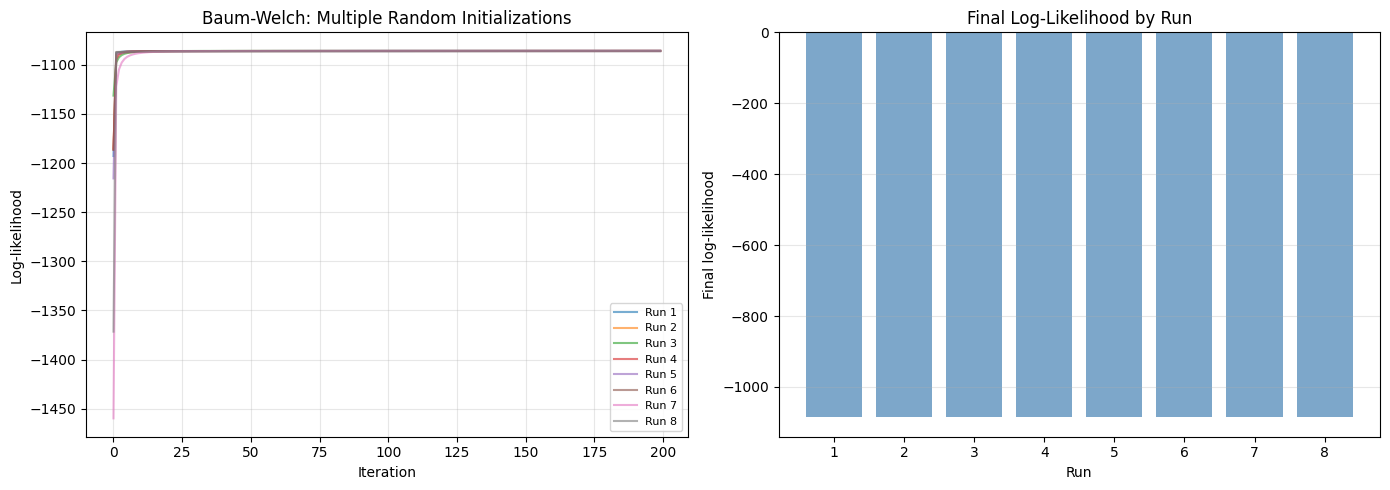

Final log-likelihoods: min=-1086.00, max=-1085.57, spread=0.42
Different initializations can converge to different local optima.


In [20]:
# Run Baum-Welch with 8 different random seeds
n_runs = 8
final_lls = []
all_curves = []

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for run in range(n_runs):
    np.random.seed(run * 17 + 3)
    _, _, _, run_lls = baum_welch(
        train_sequences, n_states=2, n_symbols=3, n_iter=200, tol=1e-8, verbose=False
    )
    all_curves.append(run_lls)
    final_lls.append(run_lls[-1])
    axes[0].plot(run_lls, alpha=0.6, label=f'Run {run+1}')

axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Log-likelihood')
axes[0].set_title('Baum-Welch: Multiple Random Initializations')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(1, n_runs+1), final_lls, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Final log-likelihood')
axes[1].set_title('Final Log-Likelihood by Run')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('em_initialization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final log-likelihoods: min={min(final_lls):.2f}, max={max(final_lls):.2f}, "
      f"spread={max(final_lls)-min(final_lls):.2f}")
print("Different initializations can converge to different local optima.")

### Summary

We implemented the EM algorithm for three model families, all following the same pattern:

| Model | Hidden variables | E-step | M-step |
|---|---|---|---|
| **Bayesian Network** | Unobserved nodes | `enumeration_ask` for posteriors | Expected counts → normalize |
| **HMM (Baum-Welch)** | Hidden states $s_t$ | Forward-backward → $\gamma$, $\xi$ | Re-estimate $\pi_i$, $a_{ij}$, $b_{ik}$ |
| **Noisy-OR** | Latent $Z_i$ variables | $P(Z_i=1 \mid \mathbf{x}, y)$ | $p_i \leftarrow$ expected activations / active count |

In every case, EM replaces hard indicator counts $I(\cdot)$ with soft posterior
expectations $P(\cdot \mid V_t = v_t)$, and the log-likelihood monotonically increases
until convergence to a local maximum.